In [56]:
# Standard
import sys, os
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir, "../")))
import config
import json
from collections import defaultdict
import pandas as pd 
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Types (optional for type hints)
from typing import List

# Your SubGraph class (assume already defined/imported)
from SubGraph import SubGraph  # Replace with actual path/module if needed


In [57]:
# Load a list of SubGraphs from a JSONL file
def load_subgraphs_from_jsonl(filepath: str) -> List[SubGraph]:
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    return [SubGraph(**json.loads(line)) for line in lines]

subgraphs = load_subgraphs_from_jsonl("../"+config.SUBGRAPHS_JSONL)
print(f"Loaded {len(subgraphs)} subgraphs.")


Loaded 6124 subgraphs.


In [62]:
def plot_fact_count_distribution(subgraphs: List[SubGraph], bins: int = 100, min_number = 10):
    """
    Plots a histogram showing how many facts each SubGraph contains,
    excluding subgraphs with 0 facts (but reports how many were skipped).

    Args:
        subgraphs: List of SubGraph objects.
        bins: Number of bins for the histogram.
    """
    fact_counts = [sg.fact_count for sg in subgraphs]
    
    # Filter out subgraphs with 0 facts
    nonzero_counts = [c for c in fact_counts if c > 0]
    reasonable_counts = [c for c in nonzero_counts if c < 100]  # Exclude outliers for better visualization
    ready_graphs = len([c for c in fact_counts if c >= min_number])
    print(f"Number of subgraphs with at least {min_number} facts: {ready_graphs}")
    zero_count = len(fact_counts) - len(nonzero_counts)
    large_count = len(nonzero_counts) - len(reasonable_counts)
    print(f"Number of subgraphs with 0 facts: {zero_count}")
    print(f"Number of subgraphs with >100 facts: {large_count}")

    plt.figure(figsize=(8, 5))
    plt.hist(reasonable_counts, bins=bins, edgecolor='black', color='steelblue')
    
    plt.xlabel("Number of Facts per SubGraph")
    plt.ylabel("Number of SubGraphs")
    plt.title("Distribution of Fact Counts (Excluding 0 or Large Counts)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Mention how many 0-fact subgraphs were excluded
    plt.legend([f"{zero_count} subgraphs with 0 facts excluded"])
    if large_count > 0:
        plt.legend([f"{zero_count} subgraphs with 0 facts excluded", 
                    f"{large_count} subgraphs with >1000 facts excluded"])
    
    plt.tight_layout()
    plt.show()



Number of subgraphs with at least 10 facts: 2123


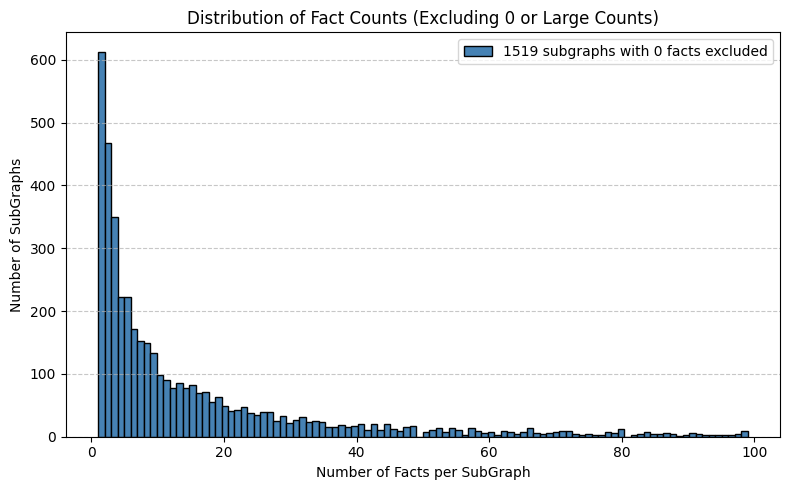

In [59]:
plot_fact_count_distribution(subgraphs)

In [60]:
def plot_valid_subgraphs_per_ticker(subgraphs: List[SubGraph], min_facts: int = 5):
    """
    Plots how many valid SubGraphs each ticker has (valid = fact_count >= min_facts).
    Includes all tickers from the metadata file, even those with 0 valid subgraphs.
    """
    # Step 1: Load all tickers from metadata CSV
    metadata = pd.read_csv("../"+config.METADATA_CSV_FILEPATH)
    all_tickers = metadata['Symbol'].dropna().unique()

    # Step 2: Count valid subgraphs per ticker
    ticker_counts = defaultdict(int)
    for sg in subgraphs:
        if sg.fact_count >= min_facts:
            ticker_counts[sg.primary_ticker] += 1

    # Step 3: Create full count dictionary (fill missing tickers with 0)
    full_counts = {ticker: ticker_counts.get(ticker, 0) for ticker in all_tickers}

    # Step 4: Sort for nicer plotting
    sorted_items = sorted(full_counts.items(), key=lambda x: x[1], reverse=True)
    tickers, counts = zip(*sorted_items) if sorted_items else ([], [])

    # Step 5: Plot
    x = np.arange(len(tickers))
    bar_width = 0.6

    plt.figure(figsize=(max(10, len(tickers) * 0.5), 6))
    plt.bar(x, counts, width=bar_width, color='skyblue', edgecolor='black')
    plt.xticks(ticks=x, labels=tickers, rotation=45, ha='right')

    # Remove excess white space
    if len(x) > 0:
        plt.xlim(x[0] - bar_width / 2, x[-1] + bar_width / 2)

    plt.xlabel("Ticker")
    plt.ylabel(f"Number of SubGraphs with ≥{min_facts} Facts")
    plt.title("Valid SubGraphs per Ticker (Including Zeros)")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    print(sorted_items)  # Print the full counts for debugging


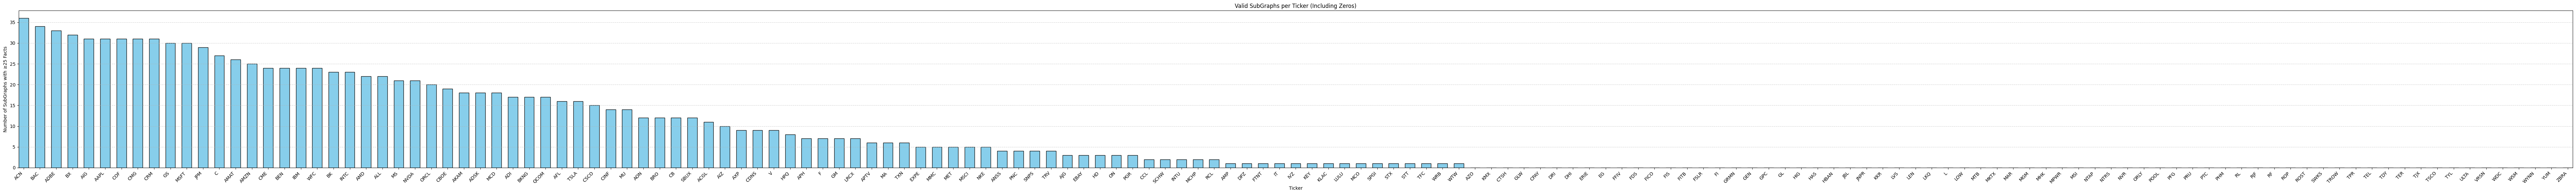

[('ACN', 36), ('BAC', 34), ('ADBE', 33), ('BX', 32), ('AIG', 31), ('AAPL', 31), ('COF', 31), ('CMG', 31), ('CRM', 31), ('GS', 30), ('MSFT', 30), ('JPM', 29), ('C', 27), ('AMAT', 26), ('AMZN', 25), ('CME', 24), ('BEN', 24), ('IBM', 24), ('WFC', 24), ('BK', 23), ('INTC', 23), ('AMD', 22), ('ALL', 22), ('MS', 21), ('NVDA', 21), ('ORCL', 20), ('CBOE', 19), ('AKAM', 18), ('ADSK', 18), ('MCD', 18), ('ADI', 17), ('BKNG', 17), ('QCOM', 17), ('AFL', 16), ('TSLA', 16), ('CSCO', 15), ('CINF', 14), ('MU', 14), ('AON', 12), ('BRO', 12), ('CB', 12), ('SBUX', 12), ('ACGL', 11), ('AIZ', 10), ('AXP', 9), ('CDNS', 9), ('V', 9), ('HPQ', 8), ('APH', 7), ('F', 7), ('GM', 7), ('LRCX', 7), ('APTV', 6), ('MA', 6), ('TXN', 6), ('EXPE', 5), ('MMC', 5), ('MET', 5), ('MSCI', 5), ('NKE', 5), ('ANSS', 4), ('PNC', 4), ('SNPS', 4), ('TRV', 4), ('AJG', 3), ('EBAY', 3), ('HD', 3), ('ON', 3), ('PGR', 3), ('CCL', 2), ('SCHW', 2), ('INTU', 2), ('MCHP', 2), ('RCL', 2), ('AMP', 1), ('DPZ', 1), ('FTNT', 1), ('IT', 1), ('IVZ'

In [61]:
plot_valid_subgraphs_per_ticker(subgraphs, min_facts=25)